In [45]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('E:\\private\\学习\\2020-bi-programing-practice\\随便写写\\intelligen_logistics\\L3-L19\\课上数据\\score_card\\cs-training.csv')

In [46]:
df_train.drop('Unnamed: 0', inplace=True, axis=1)

In [47]:
df_train.info()
df_train.head()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Text(0, 0.5, 'count')

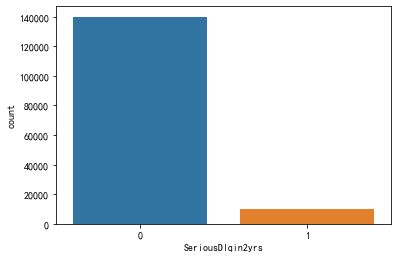

In [48]:
#查看下target SeriousDlqin2yrs的分布
#样本分布不均衡
import matplotlib.pyplot as plt
import seaborn as sns
temp = df_train['SeriousDlqin2yrs'].value_counts()
sns.barplot(x=temp.index, y=temp.values)
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('count')

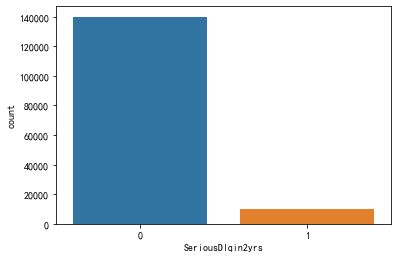

In [49]:
sns.countplot(x='SeriousDlqin2yrs', data=df_train)

In [50]:
df_train['SeriousDlqin2yrs'].sum()/len(df_train['SeriousDlqin2yrs'])

0.06684

In [51]:
for col in df_train.columns:
    print(df_train.describe()[col])

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64
count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64
count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
count    150000.000000
mean        353.005076
std        2037.818523
min         

In [52]:
df_train.describe()['SeriousDlqin2yrs']

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

### 处理缺失值，从上面可以看出MonthlyIncome，NumberOfDependents存在缺失值，这里打算通过随机森林的方式进行预测填充

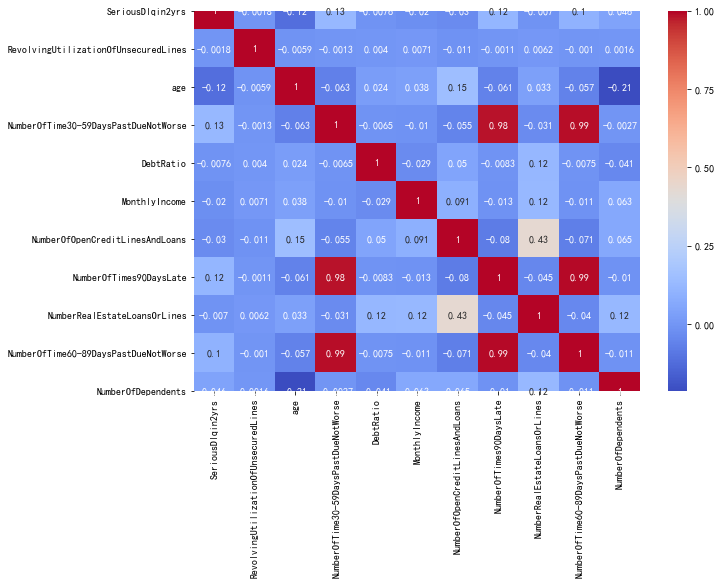

In [53]:
#先看下相关性
corr = df_train.corr()
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap='coolwarm', annot=True)

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def regression_model_stats(model, x_train, x_test, y_train, y_test, name):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    #pd.DataFrame({'hh':list(y_pred)}).to_csv('hh.csv')
    mae = mean_absolute_error(y_pred, y_test)
    mse= mean_squared_error(y_pred, y_test)
    rmse= mse ** 0.5
    r2 =r2_score(y_test, y_pred)
    print('Model used:' ,name)
    print('{} MAE:{}%' .format(name, mae))
    print('{} MSE:{}%'.format(name, mse))
    print('{} RMSE:{}'.format(name, rmse))
    print('{} R Squared:{}%'.format(name,r2))
    return mae, mse, rmse, r2

In [55]:
#预测填充MonthlyIncome
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

MonthlyIncomeTrain_y = df_train[(df_train['MonthlyIncome'].notnull()) & (df_train['MonthlyIncome'] > 10)]['MonthlyIncome'].copy()
MonthlyIncomeTrain_X =  df_train[df_train['MonthlyIncome'].notnull()  & (df_train['MonthlyIncome'] > 10)].drop(['NumberOfDependents','MonthlyIncome','SeriousDlqin2yrs'], axis=1)

MonthlyIncomeTest_X = df_train[(df_train['MonthlyIncome'].isnull()) | (df_train['MonthlyIncome'] <=10)].drop(['NumberOfDependents','MonthlyIncome','SeriousDlqin2yrs'], axis=1)
scaler = MinMaxScaler()
x_IM_train_scaler = scaler.fit_transform(MonthlyIncomeTrain_X)
x_IM_test_scaler = scaler.transform(MonthlyIncomeTest_X)

MI_train_x, MI_valid_x, MI_train_y, MI_valid_y = train_test_split(x_IM_train_scaler, MonthlyIncomeTrain_y, test_size=0.1)
#model = RandomForestRegressor(n_estimators=512,  max_depth=10)
#这里尝试了下xgboost
model = XGBRegressor(n_estimators=1000, learning_rate=0.1,  max_depth=7)
mae, mse, rmse, r2 =  regression_model_stats(model, MI_train_x, MI_valid_x, MI_train_y, MI_valid_y, 'RandomRorest')



Model used: RandomRorest
RandomRorest MAE:2617.2082517970075%
RandomRorest MSE:83551786.7886046%
RandomRorest RMSE:9140.666649025365
RandomRorest R Squared:0.2788258723098038%


In [56]:
model.predict(x_IM_test_scaler)

array([  230.41399,  -126.15487,   734.1045 , ..., 10451.512  ,
         181.61992,  3095.2795 ], dtype=float32)

In [57]:
#预测的效果好像并没有那么好，不过还是按照这个思路做
df_train.loc[(df_train['MonthlyIncome'].isnull()) | (df_train['MonthlyIncome'] <=10),'MonthlyIncome'] = model.predict(x_IM_test_scaler)

In [58]:
MonthlyIncomeTrain_X.columns
MonthlyIncomeTest_X.columns
#list(model.predict(x_IM_test_scaler))

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse'],
      dtype='object')

In [59]:
#填充NumberOfDependents
df_train['NumberOfDependents'].fillna(df_train['NumberOfDependents'].median(), inplace=True)

In [60]:
#df_train['NumberOfDependents']
df_train.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

# 数据进行分箱

In [61]:
import math
#对于age字段，分成6段 [-math.inf, 25, 40, 50, 60, 70, math.inf],自定义分箱
ages_bins= [-math.inf, 25, 40, 50, 60, 70, math.inf]
#df_train['age'].value_counts()
df_train['bin_age'] = pd.cut(df_train['age'], bins=ages_bins)
df_train[['age','bin_age']]

,age,bin_age
0,45,"(40.0, 50.0]"
1,40,"(25.0, 40.0]"
2,38,"(25.0, 40.0]"
3,30,"(25.0, 40.0]"
4,49,"(40.0, 50.0]"
...,...,...
149995,74,"(70.0, inf]"
149996,44,"(40.0, 50.0]"
149997,58,"(50.0, 60.0]"
149998,30,"(25.0, 40.0]"


In [62]:
#对于NumberOfDependents（家属人数）字段，分成6段[-math.inf,2,4,6,8,10,math.inf]
dependents_bins = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependents_bins)
df_train[['NumberOfDependents','bin_NumberOfDependents']].head()

,NumberOfDependents,bin_NumberOfDependents
0,2.0,"(-inf, 2.0]"
1,1.0,"(-inf, 2.0]"
2,0.0,"(-inf, 2.0]"
3,0.0,"(-inf, 2.0]"
4,0.0,"(-inf, 2.0]"


In [63]:
#对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段
#[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'], bins=dpd_bins)

In [64]:
#对于其余字段，即RevolvingUtilizationOfUnsecuredLines, 
#DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'], q=5, duplicates='drop')
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'], q=5, duplicates='drop')
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'], q=5, duplicates='drop')
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'], q=5, duplicates='drop')
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'], q=5, duplicates='drop')


In [65]:
bin_cols = [c for c in df_train.columns if c.startswith('bin_')]
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [66]:
#计算IV值， 衡量自变量的预测能力
def cal_IV(df, feature, target):
    cols = ['col','value','all','bad','good']
    base_list = []
    for val in df[feature].unique():
        count = df[df[feature] == val][feature].count()
        bad = df[(df[feature] == val ) & (df[target] == 1)][feature].count()
        good = df[(df[feature] == val ) & (df[target] == 0)][feature].count()
        base_list.append([feature, val , count, bad, good])
    data = pd.DataFrame(base_list, columns=cols)
    data['margin_bad_rate'] = data['bad']/data['bad'].sum()
    data.loc[data['margin_bad_rate']== 0, 'margin_bad_rate'] = 0.00001
    data['margin_good_rate'] = data['good']/data['good'].sum()
    #这个地方很奇怪，老师视频中没有出现在Rbin_NumberOfDependents下，会出现 log为0时的-inf的报警，untimeWarning: divide by zero encountered in log
    data['WOE'] = np.log(data['margin_bad_rate']/data['margin_good_rate']) 
    data['IV'] = (data['margin_bad_rate'] - data['margin_good_rate'])*data['WOE']
    #print(data)
    print(feature, data['IV'].sum())
    return data['IV'].sum()

In [67]:
# 里面数据的确有问题，所以这里要处理下为0的情况
df_train[df_train['NumberOfDependents'] >=10][['NumberOfDependents','SeriousDlqin2yrs']]

,NumberOfDependents,SeriousDlqin2yrs
6299,20.0,0
10618,10.0,0
12982,10.0,0
22698,10.0,0
39095,10.0,0
123911,10.0,0
128034,13.0,0


In [68]:
#cal_IV(df_train, 'bin_NumberOfDependents', 'SeriousDlqin2yrs')
#筛选出大于IV>0.1的col
select_bin_col=[]
for col in bin_cols:
    IV = cal_IV(df_train, col, 'SeriousDlqin2yrs')
    if IV>=0.1:
        select_bin_col.append(col)

bin_age 0.24041120302785982
bin_NumberOfDependents 0.01463012170541098
bin_NumberOfTime30-59DaysPastDueNotWorse 0.492444774570198
bin_NumberOfTime60-89DaysPastDueNotWorse 0.26655914618929066
bin_NumberOfTimes90DaysLate 0.49160685733515563
bin_RevolvingUtilizationOfUnsecuredLines 1.0596188771423887
bin_DebtRatio 0.05948761145809681
bin_MonthlyIncome 0.062171866996108154
bin_NumberOfOpenCreditLinesAndLoans 0.04802315528985505
bin_NumberRealEstateLoansOrLines 0.0120914141106244


In [69]:
select_bin_col

['bin_age',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines']

In [70]:
def cal_WOE(df, feature, target):
    df_woe = df.groupby([feature]).agg({target:['sum','count']})
    df_woe.columns = list(map(''.join, df_woe.columns.values))
    df_woe = df_woe.reset_index()
    df_woe = df_woe.rename(columns={target+'sum':'bad', target+'count':'all'})
    #计算WOE
    #print(df_woe)
    df_woe['good_rate'] = (df_woe['all'] - df_woe['bad'])/(df_woe['all'].sum() - df_woe['bad'].sum())
    df_woe['bad_rate'] = df_woe['bad']/df_woe['bad'].sum()
    df_woe.loc[df_woe['bad_rate']== 0, 'bad_rate'] = 0.00001
    df_woe[feature+'_WOE'] = np.log(df_woe['bad_rate']/df_woe['good_rate'])
    df =df.merge(df_woe[[feature, feature+'_WOE']], on=feature, how='left')
    print(df_woe)
    return df

In [71]:
df_train_new = df_train.copy()
#df_train_new = cal_WOE(df_train, 'bin_age','SeriousDlqin2yrs')
for col in select_bin_col:
    df_train_new = cal_WOE(df_train_new, col,'SeriousDlqin2yrs')

        bin_age   bad    all  good_rate  bad_rate  bin_age_WOE
0  (-inf, 25.0]   338   3028   0.019218  0.033712     0.562024
1  (25.0, 40.0]  3296  32069   0.205560  0.328745     0.469547
2  (40.0, 50.0]  2893  35037   0.229643  0.288550     0.228343
3  (50.0, 60.0]  2149  34806   0.233308  0.214343    -0.084782
4  (60.0, 70.0]   952  27424   0.189121  0.094953    -0.689003
5   (70.0, inf]   398  17636   0.123151  0.039697    -1.132145
  bin_NumberOfTime30-59DaysPastDueNotWorse   bad     all  good_rate  bad_rate  \
0                              (-inf, 1.0]  7450  142051   0.961614  0.743068   
1                               (1.0, 2.0]  1219    4598   0.024140  0.121584   
2                               (2.0, 3.0]   618    1754   0.008116  0.061640   
3                               (3.0, 4.0]   318     747   0.003065  0.031718   
4                               (4.0, 5.0]   154     342   0.001343  0.015360   
5                               (5.0, 6.0]    74     140   0.000472  0.00

In [72]:
df_train_new.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bin_age', 'bin_NumberOfDependents',
       'bin_NumberOfTime30-59DaysPastDueNotWorse',
       'bin_NumberOfTime60-89DaysPastDueNotWorse',
       'bin_NumberOfTimes90DaysLate',
       'bin_RevolvingUtilizationOfUnsecuredLines', 'bin_DebtRatio',
       'bin_MonthlyIncome', 'bin_NumberOfOpenCreditLinesAndLoans',
       'bin_NumberRealEstateLoansOrLines', 'bin_age_WOE',
       'bin_NumberOfTime30-59DaysPastDueNotWorse_WOE',
       'bin_NumberOfTime60-89DaysPastDueNotWorse_WOE',
       'bin_NumberOfTimes90DaysLate_WOE',
       'bin_RevolvingUtilizationOfUnsecuredLines_WOE'],
      dtype='object')